## Loading and Visualizing Stellar Catalog

Tools used:

1. pandas

In [1]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

import matplotlib

matplotlib.style.use('ggplot')

from scipy.spatial.distance import pdist, squareform

import networkx as nx

I have downloaded the coordinate for stars from [this post](http://allthingsgraphed.com/2014/12/05/stellar-navigation-using-network-analysis/#data).

Using pandas I can load the data into DataFrame.

In [2]:
stars=pd.read_csv('assets/stars.csv')

I need to know what unit they are using. So I sort the data frame according to distance. The result shows that GI551, which is proxima centari, is 4.226 distance away from Sun. Then I know the unit is lightyear.

In [3]:
stars.sort_values('dist', ascending=True)

,#Name,x-pos,y-pos,z-pos,dist,bright,temp
0,Sun,0.0000,0.0000,0.0000,0.0000,1.0000,5778.4237
78,Gl-551,2.9331,-3.0390,0.1443,4.2260,0.0001,3356.3732
97,Gl-559A,3.1203,-3.0371,0.0539,4.3547,1.5417,5815.2137
96,Gl-559B,3.1203,-3.0371,0.0539,4.3547,0.4529,5162.9390
1078,Gl-699,4.9811,2.9792,-1.4457,5.9814,0.0004,3464.9272
...,...,...,...,...,...,...,...
675,Wo-9666,64.5812,29.5029,23.5606,74.8081,3.3729,6576.0503
1453,Gl-499.1,6.9555,-2.4428,-74.6168,74.9801,2.6303,3662.9729
1934,Wo-9648A,11.6078,70.6536,-22.2562,74.9801,1.0864,5778.4237
1933,Wo-9648B,11.6109,70.6523,-22.2586,74.9801,0.9204,5778.4237


To have a sense of the distribution, we can plot some histograms.

In [57]:
stars['dist'].sort_values()

0        0.0000
78       4.2260
97       4.3547
96       4.3547
1078     5.9814
         ...   
675     74.8081
1453    74.9801
1934    74.9801
1933    74.9801
210     74.9801
Name: dist, Length: 2223, dtype: float64

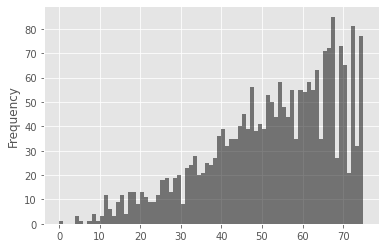

In [58]:
fig, ax = plt.subplots()

plotstarshist=stars['dist'].plot.hist(color='k', alpha=0.5, bins=75, range=[0, 75], ax=ax)

which is an expected histogram in general since the differential volume for larger distances becomes larger.

I could also calculate the relative distances between each other.

I can either write a function that calculates the distances or use the pdist function in scipy.

In [59]:
squareform( pdist(stars[['x-pos','y-pos','z-pos']].values, metric='euclidean')  ).flatten()

array([ 0.        , 57.62606369, 56.235066  , ..., 18.11713099,
        4.09187698,  0.        ])

In [62]:
dist_mat = pd.DataFrame(
    pd.DataFrame(
        squareform(
            pdist(stars[['x-pos','y-pos','z-pos']].values, metric='euclidean') 
        ).flatten()
    ).values.flatten()
)

<AxesSubplot:ylabel='Frequency'>

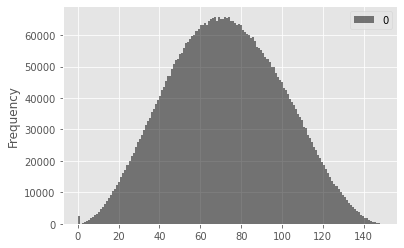

In [61]:
dist_mat.plot.hist(color='k', alpha=0.5, bins=150)

So the stars seems to be quite homogeneous, given the furthest star from Sun in this database is around 75ly. The distribution seems to be around this distance.

### Distances

To calculate shortest distances, I need to use graph packages. Here I choose networkx.

networkx can import pandas dataframe directly but I need to insert a column of source vertex and target vertex into the data frame.

Generate the source column and target column first.

In [10]:
print(
    dist_mat.values.flatten().shape[0] / stars['#Name'].values.shape[0], stars['#Name'].values.shape[0]
)

2223.0 2223


In [11]:
sourceCol = np.transpose(\
             np.array( [ stars['#Name'].values for __ in range( stars['#Name'].values.shape[0] )\
          ])\
            ).flatten()

In [12]:
targetCol = np.array( [ stars['#Name'].values for __ in range( stars['#Name'].values.shape[0] )\
          ]).flatten()


In [14]:
print(
    sourceCol.shape, targetCol.shape, dist_mat.values.shape
)

(4941729,) (4941729,) (4941729, 1)


In [15]:
dist_mat.insert(1,'source',sourceCol)
dist_mat.insert(2,'target',targetCol)

I noticed that I forget to change the name of distance of the data frame.

In [16]:
dist_mat.columns = ['distance', 'source', 'target']

In [17]:
dist_mat

,distance,source,target
0,0.000000,Sun,Sun
1,57.626064,Sun,Gl-385
2,56.235066,Sun,Gl-67.1
3,56.332177,Sun,Gl-820.1
4,74.127999,Sun,GJ-2108
...,...,...,...
4941724,9.889712,NN-3768,Gl-699.1
4941725,20.158084,NN-3768,GJ-1101
4941726,18.117131,NN-3768,GJ-1035
4941727,4.091877,NN-3768,Gl-396


In [20]:
#StarGraph = nx.from_pandas_dataframe(dist_mat, 'source', 'target', 'distance')
StarGraph = nx.from_pandas_edgelist(dist_mat, 'source', 'target', 'distance')

In [21]:
StarGraph['Sun']['Sun']['distance']

0.0

I can calculate the shortest path

In [22]:
print( [p for p in nx.all_shortest_paths(StarGraph, source='Sun', target='GJ-2108', weight='distance')] )

[['Sun', 'GJ-2108'], ['Sun', 'GJ-2108']]


Now it seems the graph is working because direct flight is the shortest path in space.

### For a certain finite flight distance

In [23]:
dist10df = dist_mat[dist_mat['distance']<10]

In [24]:
dist10df

,distance,source,target
0,0.000000,Sun,Sun
78,4.226041,Sun,Gl-551
96,4.354670,Sun,Gl-559B
97,4.354670,Sun,Gl-559A
538,9.562127,Sun,Gl-729
...,...,...,...
4941718,5.115011,NN-3768,NN-3859
4941719,6.989133,NN-3768,NN-3675
4941724,9.889712,NN-3768,Gl-699.1
4941727,4.091877,NN-3768,Gl-396


In [25]:
dist10df.to_csv('dist10df.csv', sep=',',index=False)

In [27]:
StarGraph10 = nx.from_pandas_edgelist(dist10df, 'source', 'target', 'distance')

In [28]:
nx.shortest_path(StarGraph10, source='Sun', target='Gl-305', weight='distance')

['Sun',
 'Gl-551',
 'Gl-845',
 'Gl-780',
 'Gl-19',
 'Gl-902',
 'Gl-865',
 'Gl-842',
 'GJ-1279',
 'Gl-855.1A',
 'Gl-808',
 'Gl-820.1',
 'Gl-67.1',
 'Wo-9189',
 'Gl-305']

In [29]:
print( [p for p in nx.all_shortest_paths(StarGraph10, source='Sun', target='Gl-305', weight='distance')] )

[['Sun', 'Gl-551', 'Gl-845', 'Gl-780', 'Gl-19', 'Gl-902', 'Gl-865', 'Gl-842', 'GJ-1279', 'Gl-855.1A', 'Gl-808', 'Gl-820.1', 'Gl-67.1', 'Wo-9189', 'Gl-305'], ['Sun', 'Gl-551', 'Gl-845', 'Gl-780', 'Gl-19', 'Gl-902', 'Gl-865', 'Gl-842', 'GJ-1279', 'Gl-855.1A', 'Gl-808', 'Gl-820.1', 'Gl-67.1', 'Wo-9189', 'Gl-305']]


In [30]:
print(
    nx.dijkstra_path(StarGraph10,'Sun','Gl-305'), '\n' , nx.dijkstra_path(StarGraph10,'Sun','Gl-305',weight='distance')
)

['Sun', 'Gl-551', 'Gl-845', 'Gl-780', 'Gl-19', 'Gl-902', 'Gl-865', 'Gl-842', 'GJ-1279', 'NN-4340', 'Gl-808', 'Gl-820.1', 'Gl-67.1', 'Wo-9189', 'Gl-305'] 
 ['Sun', 'Gl-551', 'Gl-845', 'Gl-780', 'Gl-19', 'Gl-902', 'Gl-865', 'Gl-842', 'GJ-1279', 'Gl-855.1A', 'Gl-808', 'Gl-820.1', 'Gl-67.1', 'Wo-9189', 'Gl-305']


Now which is the most frequent stellar system?

In [31]:
dist10df['source'].shape

(15085,)

In [32]:
dist10dfSC = dist10df['source'].value_counts()

In [33]:
dist10dfSC

Gl-663A     21
Gl-663B     21
Gl-664      19
Gl-729      18
Gl-674      18
            ..
NN-3392      1
GJ-2108      1
Gl-875.1     1
Gl-257A      1
NN-3862      1
Name: source, Length: 2223, dtype: int64

To get more out of this calculation, we print out the distance from Sun for the most frequently visted stars. Of course we have been assuming a homogeneous trading/travelling network. In general this is not true.

In [35]:
for i in range( dist10dfSC[dist10dfSC > 15].values.shape[0]  ):
    print(
        dist_mat[ (dist_mat['target'] == dist10dfSC.index[i]) & (dist_mat['source'] == 'Sun') ]['distance'].values, dist10dfSC[dist10dfSC > 15].values[i]
    )

[17.3861465] 21
[17.38611038] 21
[17.92108462] 19
[9.56212713] 18
[14.84581102] 18
[31.15222331] 18
[28.33734858] 18
[28.33742726] 18
[13.47226589] 17
[55.18839962] 17
[12.94812881] 17
[12.94812881] 17
[40.26706168] 17
[15.414186] 17
[36.11996607] 17
[42.91619987] 16
[41.54952551] 16
[19.75547698] 16
[18.30323682] 16
[10.33467594] 16
[44.07612787] 16
[35.29905833] 16
[35.76350073] 16
[14.56084008] 16
[35.84208863] 16
[13.3291135] 16
[7.79733777] 16


In principle, the more human-friendly planets a star system has, the more likely the transportation flights are going to visit it. Also if the star system have many neighbours with a lot of planets, the star system is likely to be some hub.

For an assumption, we can assume some function of the value of a star system using the idea of planets.

## More Systematic Methods

Defining Functions

In [36]:
def DistanceMatrix(stars_dataframe):
    
    return pd.DataFrame( \
                        pd.DataFrame( \
                                     squareform( \
                                                pdist(stars_dataframe[['x-pos','y-pos','z-pos']].values, metric='euclidean') \
                                               ).flatten() \
                                    ).values.flatten() \
                       )
    

In [37]:
def SourceColumn(stars_dataframe): 
    
    return np.transpose(\
             np.array( [ stars_dataframe['#Name'].values for __ in range( stars_dataframe['#Name'].values.shape[0] )\
          ])\
            ).flatten()

In [38]:
def TargetColumn(stars_dataframe):

    return np.array( [ stars_dataframe['#Name'].values for __ in range( stars_dataframe['#Name'].values.shape[0] )\
          ]).flatten()


### The Graph is too large

Truncate it using the distance to the Sun.

In [39]:
stars_30 = stars[stars['dist']<30]
stars_30.sort_values('dist', ascending=True)

,#Name,x-pos,y-pos,z-pos,dist,bright,temp
0,Sun,0.0000,0.0000,0.0000,0.0000,1.0000,5778.4237
78,Gl-551,2.9331,-3.0390,0.1443,4.2260,0.0001,3356.3732
97,Gl-559A,3.1203,-3.0371,0.0539,4.3547,1.5417,5815.2137
96,Gl-559B,3.1203,-3.0371,0.0539,4.3547,0.4529,5162.9390
1078,Gl-699,4.9811,2.9792,-1.4457,5.9814,0.0004,3464.9272
...,...,...,...,...,...,...,...
1967,NN-3421,-26.4425,7.5620,-11.7205,29.8958,0.0003,3344.7435
877,Gl-250A,-23.7001,-18.2778,1.1280,29.9507,0.1690,4625.8097
876,Gl-250B,-23.6953,-18.2838,1.1319,29.9507,0.0067,3793.5065
261,Gl-367,1.1680,-29.8086,-2.9632,29.9782,0.0067,3748.9340


In [40]:
dist_mat_30 = DistanceMatrix(stars_30)
dist_mat_30

,0
0,0.000000
1,26.517379
2,20.988639
3,27.202962
4,28.585720
...,...
56164,8.397085
56165,7.709603
56166,15.756504
56167,10.845875


In [42]:
print(
    dist_mat_30.values.flatten().shape[0] / stars_30['#Name'].values.shape[0], stars_30['#Name'].values.shape[0]
)

237.0 237


In [43]:
dist_mat_30.insert(1,'source',SourceColumn(stars_30))
dist_mat_30.insert(2,'target',TargetColumn(stars_30))

In [44]:
dist_mat_30.columns = ['distance', 'source', 'target']

In [45]:
dist_mat_30

,distance,source,target
0,0.000000,Sun,Sun
1,26.517379,Sun,GJ-1123
2,20.988639,Sun,Gl-19
3,27.202962,Sun,Gl-877
4,28.585720,Sun,Gl-231
...,...,...,...
56164,8.397085,Gl-445,Gl-764
56165,7.709603,Gl-445,GJ-1221
56166,15.756504,Gl-445,Gl-48
56167,10.845875,Gl-445,Gl-713AB


In [46]:
dist10df_30 = dist_mat_30[dist_mat_30['distance']<10]

In [47]:
dist10df_30.to_csv('dist10df_30.csv', sep=',',index=False)

In [48]:
dist10df_30_st = dist10df_30[['source','target']]
dist10df_30_st.to_csv('dist10df_30_st.csv', sep=',',index=False) # only source and target column

In [49]:
def FindTargets_dist10df_30_st(source_name):
    
    return dist10df_30_st[ dist10df_30_st['source']==source_name ]['target'].values

In [50]:
FindTargets_dist10df_30_st('Sun')

array(['Sun', 'Gl-551', 'Gl-559B', 'Gl-559A', 'Gl-729', 'Gl-65A',
       'Gl-244B', 'Gl-244A', 'Gl-699', 'Gl-406', 'Gl-411'], dtype=object)

In [51]:
flarejsondf = pd.DataFrame(columns=['source','targets', 'bright', 'temp'])

In [52]:
dist10df_30_st['source'].value_counts().index

Index(['Gl-663B', 'Gl-663A', 'Gl-664', 'Gl-674', 'Gl-729', 'Gl-860B',
       'Gl-860A', 'Gl-234A', 'Gl-682', 'NN-3522',
       ...
       'NN-3192A', 'Gl-318', 'Gl-506', 'Gl-367', 'GJ-2034', 'Gl-791.2',
       'Gl-785', 'NN-4247', 'Gl-257A', 'Gl-595'],
      dtype='object', length=237)

In [53]:
stars[stars['#Name']=='Sun']['bright']

0    1.0000
Name: bright, dtype: object

In [54]:
i_flag = 0
for source in dist10df_30_st['source'].value_counts().index:
    
    flarejsondf.loc[i] = [source, FindTargets_dist10df_30_st(source), stars[stars['#Name']==source]['bright'].values[0], stars[stars['#Name']==source]['temp'].values[0]]
    
    i = i + 1

In [55]:
flarejsondf

,source,targets,bright,temp
26,Gl-663B,"[Gl-674, Gl-754, Gl-682, Gl-588, Gl-618B, Gl-6...",0.2228,5106.1369
27,Gl-663A,"[Gl-674, Gl-754, Gl-682, Gl-588, Gl-618B, Gl-6...",0.2312,5134.3712
28,Gl-664,"[Gl-674, Gl-754, Gl-682, Gl-588, Gl-618B, Gl-6...",0.0773,4388.7408
29,Gl-674,"[Gl-780, Gl-693, Gl-845, Gl-674, Gl-666B, Gl-6...",0.0032,3748.9340
30,Gl-729,"[Sun, Gl-551, Gl-559B, Gl-559A, Gl-845, Gl-674...",0.0005,3490.0442
...,...,...,...,...
258,Gl-791.2,"[Gl-791.2, Gl-829]",0.0004,3581.0028
259,Gl-785,"[Gl-799A, Gl-785]",0.3767,5050.6447
260,NN-4247,"[Gl-829, NN-4247]",0.0011,3607.9005
261,Gl-257A,[Gl-257A],0.0017,3567.7091


In [56]:
flarejsondf.reset_index().to_json('dist10df_30.json', orient='records')

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=d32cfec2-50b1-49c8-8e19-ffc8cad5ea31' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>